In [291]:
#Used for downloading anything
!pip install nba_api
!pip install openpyxl

     |████████████████████████████████| 242 kB 3.7 MB/s eta 0:00:01


# NBA Betting Models
## Introduction
I have watched sports since I was six years old. I have been watching sice then and have recently started sports betting. Since beginning my study of data science and economics, I've became interested in developing a sports betting model. This will be my attempt to develop this. Along the way, I hope to learn a lot about how we model sports betting. I will be using data from nba.com to get my testing data. There's a very helpful API that exists for scraping data from this website that I will be using a lot. This can be found here at https://github.com/swar/nba_api. It should be mentioned here that I will be looking at data from very specific years. I am going to ignore any year before 2015 as previous to this the game of basketball was played vastly differently than it is in 2022 and going forward. In addition I will ignore the 2019-2020 and 2020-2021 seasons. This is due to the fact that the amount of games was different, fans were not present, and rest was completely different. 

The ultimate goal of this project will be to model two things. The first is the total from a game between two opponents. The goal is to be able to predict how many points the teams will combine for. This in turn will allow us to decide on a bet for the total. The other goal will be to model the predicted spread between two teams. 

## Master Data
In this section I will help to instantiate some dataframes that can help be used along many of the betting model analyses I will conduct. I hope to establish two main dataframes. One will be a master schedule table. Essentially an entry for every team in every game with advanced statistics provided by the API. So essentially it will have every regular season game with an entry for each team. 

In addition I will also conduct a sort of year by year record for each team. Basically an entry for every team in every year with a bunch of cumulative statistics as our columns. My hope is that I can look at the correlation between point volatility, wins, points, and other stastics to get an inkling of where to model.

#### Importing Libraries and Establishing Constants

In [189]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
nba_teams = teams.get_teams()
years = ['22014', '22015', '22016', '22017', '22018', '22021'] # These will be the starting years for each season

#### Work on Master Schedule
Go through all of the teams and grab all of their games. Add the ones where the year is in one of our selected seasons that we declared at the top. Then add to the existing games. 

#### Filter to Just Regular Season Games
In this step, I'm just slicing the data to get regular season games. Through looking at the data, these qualifications get only regular season games.

In [197]:
m_sched = pd.DataFrame()

for team in nba_teams: 
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team['id'])
    df = gamefinder.get_data_frames()[0]
    relev = df[df.SEASON_ID.str[-4:].isin(years)]
    m_sched = pd.concat([m_sched, relev])
    
m_sched = m_sched[m_sched['SEASON_ID'].astype(int) > 20000]
m_sched = m_sched[m_sched['SEASON_ID'].astype(int) < 29999]
m_sched = m_sched[m_sched['MIN'] > 235]
m_sched['GAME_DATE'] = m_sched.apply(lambda row: datetime.datetime.strptime(row["GAME_DATE"], "%Y-%m-%d"), axis = 1) #To help with calculating rest
m_sched['MONTH'] = m_sched.apply(lambda row: int(row['GAME_DATE'].month), axis=1)
m_sched = m_sched[m_sched['MONTH'] != 7]
m_sched = m_sched[m_sched['MONTH'] != 6]
m_sched = m_sched[m_sched['MONTH'] != 8]
m_sched = m_sched[m_sched['MONTH'] != 9]

m_sched.to_csv('games.csv')

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

#### Load in Our CSV
At this point we now have our master games schedule. Every game a team has played in the regular season with various statistics attached. 

#### Data Transformation
At this point I've loaded in some of the most raw data that comes from a basketball game. However, I now want to add some features to our data set that will combine multiple of these raw statistics. Each of these will put the data in a better perspective. For every game I would like to add the teams eFG% ((FGM + 0.5 * 3PM) / FGA), REST (days in between games), POSS ((FGA - OR) + TOV + (.44 * FTA)), TOV% (100 * TOV / POSS), ORTG (100 * PTS / POSS). I'd also like to add PACE. PACE is essentially possesions but includes minutes played in the game. This way overtimes won't have absurdly high possession values.
Some of these require simple formulas, others require more of a script to derive (rest). I believe all will be important when it comes to modeling.

In [200]:
m_sched = pd.read_csv('games.csv')

m_sched['POSS'] = m_sched.apply(lambda row: (row['FGA'] - row['OREB']) + row['TOV'] + (.44 * row['FTA']), axis=1)
m_sched['eFGP'] = m_sched.apply(lambda row: (row['FGM'] + (.5 * row['FG3M'])) / row['FGA'], axis=1)
m_sched['TOV%'] = m_sched.apply(lambda row: 100 * (row['TOV'] / row['POSS']), axis=1)
m_sched['ORTG'] = m_sched.apply(lambda row: 100 * (row['PTS'] / row['POSS']), axis=1)
m_sched['PACE'] = m_sched.apply(lambda row: 48 * (row['POSS'] / (row['MIN'] / 5)), axis=1)
m_sched['REST'] = 0 # Will be caluclated in next step
m_sched['GAME_DATE'] = m_sched.apply(lambda row: datetime.datetime.strptime(row["GAME_DATE"], "%Y-%m-%d"), axis = 1) #To help with calculating rest

array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
       1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
       1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
       1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
       1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
       1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

#### Calculating Rest
From a previous project, I had looked at how rest effects an NBA teams performance. The script below is from that project and will calculate rest for games. A -1 will represent the start of the season for now but at some point a value will have to be imputed for these games. 

In [484]:
m_sched = m_sched.sort_values('GAME_DATE')
for year, sec in m_sched.groupby(['SEASON_ID']):
    for team, group in sec.groupby(['TEAM_ID']):
            i= 0 
            prev_idx = -1
            for idx, row in group.iterrows():
                if(i == 0):
                    # At start of the season we don't really want to evaluate the rest in between games
                    # So we put a value that doesn't make sense of -1, that way we will not include it later
                    m_sched.at[idx, 'REST'] = -1
                else: 
                    m_sched.at[idx, 'REST'] = (row['GAME_DATE'] - m_sched.at[prev_idx, 'GAME_DATE']).days
                prev_idx = idx
                i += 1

#### Generating our Year by Year Record 
Now with our master schedule data frame (m_sched), I'd like to generate a dataframe with some season cumulative statsitics for teams. This will allow me to do some exploratory data analysis on how different statistics effect eachother. Let's look at what information would be nice to have in a record table like this. These statistics will be mean per game and also the variance of these statistics. Some of these values are very irrelevant and will be removed as a result. 

Creating this table will obviously take multiple steps.

##### Cumulative Statistics from m_sched 
Let's use groupby and get some cumulative statistics to add to our table.

In [485]:
means = m_sched.groupby(['SEASON_ID', 'TEAM_ABBREVIATION']).agg("mean")
cols_drop = ['Unnamed: 0', 'TEAM_ID', 'GAME_ID', 'MIN', 'MONTH']
means.drop(cols_drop, inplace=True, axis=1)
means

PTS        FGM        FGA    FG_PCT  \
SEASON_ID TEAM_ABBREVIATION                                               
22014     ATL                102.548780  38.060976  81.695122  0.467183   
          BKN                 98.024390  37.426829  82.975610  0.452268   
          BOS                101.365854  38.939024  87.939024  0.444329   
          CHA                 94.158537  35.524390  84.536585  0.420634   
          CHI                100.792683  36.597561  82.890244  0.443183   
...                                 ...        ...        ...       ...   
22021     SAC                110.304878  40.500000  88.085366  0.460927   
          SAS                113.158537  43.243902  92.695122  0.467024   
          TOR                109.390244  40.634146  91.329268  0.445695   
          UTA                113.609756  40.573171  86.182927  0.471561   
          WAS                108.621951  40.573171  86.048780  0.472195   

                                  FG3M       FG3A   FG3_PCT        FTM  \
SEASON_ID TEAM_ABBREVIATION                                              
22014     ATL                 9.975610  26.243902  0.380146  16.451220   
          BKN                 6.597561  19.914634  0.327195  16.573171   
          BOS                 8.048780  24.646341  0.326183  15.439024   
          CHA                 6.073171  19.097561  0.312976  17.036585   
          CHI                 7.865854  22.256098  0.353585  19.731707   
...                                ...        ...       ...        ...   
22021     SAC                11.426829  33.195122  0.346268  17.878049   
          SAS                11.280488  32.024390  0.350598  15.390244   
          TOR                11.939024  34.243902  0.349037  16.182927   
          UTA                14.536585  40.341463  0.359866  17.926829   
          WAS                10.487805  30.634146  0.342939  16.987805   

                                   FTA    FT_PCT  ...       BLK        TOV  \
SEASON_ID TEAM_ABBREVIATION                       ...                        
22014     ATL                21.158537  0.776512  ...  4.634146  13.451220   
          BKN                22.158537  0.748122  ...  4.146341  13.390244   
          BOS                20.463415  0.756744  ...  3.585366  13.268293   
          CHA                22.768293  0.747573  ...  5.463415  11.170732   
          CHI                25.207317  0.781890  ...  5.804878  13.170732   
...                                ...       ...  ...       ...        ...   
22021     SAC                23.268293  0.768561  ...  4.500000  13.536585   
          SAS                20.402439  0.754744  ...  4.914634  12.304878   
          TOR                21.329268  0.761720  ...  4.585366  11.646341   
          UTA                23.365854  0.770354  ...  4.902439  13.158537   
          WAS                21.682927  0.780049  ...  4.951220  12.646341   

                                    PF  PLUS_MINUS        POSS      eFGP  \
SEASON_ID TEAM_ABBREVIATION                                                
22014     ATL                17.768293    5.426829   95.736585  0.528550   
          BKN                19.256098   -2.878049   95.798537  0.492509   
          BOS                21.195122    0.158537   99.113659  0.490271   
          CHA                18.219512   -3.146341   95.725366  0.456766   
          CHI                18.231707    3.000000   95.457073  0.491022   
...                                ...         ...         ...       ...   
22021     SAC                18.926829   -5.463415  102.299024  0.525913   
          SAS                18.085366    0.121951  102.989268  0.528029   
          TOR                19.597561    2.160976   99.006829  0.511147   
          UTA                18.865854    6.204878   98.841951  0.556258   
          WAS                18.841463   -3.378049   99.247805  0.533255   

                                  TOV%        ORTG        PACE      REST  
SEASON_ID TEAM_ABB

##### Calculating Variances 

In [486]:
vols = m_sched.groupby(['SEASON_ID', 'TEAM_ABBREVIATION']).agg("std")

cols_drop = ['Unnamed: 0', 'TEAM_ID', 'GAME_ID', 'MIN']
vols.drop(cols_drop, inplace=True, axis=1)
vols

PTS       FGM       FGA    FG_PCT  \
SEASON_ID TEAM_ABBREVIATION                                            
22014     ATL                10.582016  4.462042  5.469758  0.057591   
          BKN                12.090171  5.040651  7.147434  0.057472   
          BOS                10.492222  4.728029  7.480588  0.054022   
          CHA                11.945834  5.379948  6.955227  0.056902   
          CHI                10.752821  4.599677  7.412046  0.054464   
...                                ...       ...       ...       ...   
22021     SAC                13.577113  5.402903  7.298235  0.057195   
          SAS                13.275308  5.231814  6.612164  0.051073   
          TOR                12.263321  5.189049  6.811492  0.052854   
          UTA                10.985688  4.748048  5.303453  0.054317   
          WAS                12.706215  5.057766  6.434672  0.051614   

                                 FG3M      FG3A   FG3_PCT       FTM       FTA  \
SEASON_ID TEAM_ABBREVIATION                                                     
22014     ATL                3.063024  4.409756  0.098437  5.850298  6.982287   
          BKN                3.034207  4.690945  0.123597  5.305554  6.370204   
          BOS                2.693854  5.085375  0.079548  5.400269  6.655908   
          CHA                2.604746  4.702533  0.103146  5.167432  6.418143   
          CHI                2.651634  4.768236  0.093563  6.198464  7.304215   
...                               ...       ...       ...       ...       ...   
22021     SAC                2.893289  5.174579  0.077432  5.109638  6.299224   
          SAS                3.504052  5.891982  0.084069  6.275085  7.817138   
          TOR                3.297390  5.934958  0.082680  4.648451  5.811982   
          UTA                3.638597  6.176857  0.069058  5.286322  6.775978   
          WAS                3.159324  5.534431  0.083457  5.895162  6.963535   

                               FT_PCT  ...       TOV        PF  PLUS_MINUS  \
SEASON_ID TEAM_ABBREVIATION            ...                                   
22014     ATL                0.095478  ...  3.388989  3.755815   12.973887   
          BKN                0.115367  ...  4.162609  4.276871   15.405939   
          BOS                0.100238  ...  3.829866  4.307441   11.723638   
          CHA                0.100544  ...  3.284099  3.754912   14.889819   
          CHI                0.082028  ...  3.999398  4.025532   12.260546   
...                               ...  ...       ...       ...         ...   
22021     SAC                0.085745  ...  3.147388  3.727709   13.897504   
          SAS                0.109747  ...  3.287421  4.040539   14.812732   
          TOR                0.110500  ...  3.342107  3.589628   14.523423   
          UTA                0.087119  ...  3.811838  3.828942   15.052008   
          WAS                0.106413  ...  3.834129  4.035244   13.153078   

                                MONTH      POSS      eFGP      TOV%  \
SEASON_ID TEAM_ABBREVIATION                                           
22014     ATL                4.594175  4.453342  0.067938  3.370854   
          BKN                4.540974  5.870283  0.069518  4.145260   
          BOS                4.494250  6.153203  0.058566  3.704332   
          CHA                4.532196  6.633219  0.062399  3.284634   
          CHI                4.577102  5.881745  0.061185  3.931564   
...                               ...       ...       ...       ...   
22021     SAC                4.616862  5.261746  0.066240  3.035475   
          SAS                4.597107  5.703994  0.061379  3.031362   
          TOR                4.443581  5.370029  0.063109  3.136392   
          UTA                4.569843  5.164394  0.066918  3.596744   
          WAS                4.537923  5.600234  0.061416  3.744578   

                                  ORTG      PACE      REST  
SEASON_ID TEAM_ABBREVIATION                 

##### Combining Means with Standard Deviation

In [487]:
record = means.join(vols, ['SEASON_ID', 'TEAM_ABBREVIATION'], rsuffix='_VAR')

##### Calculating Wins

In [488]:
record['WINS'] = 0
wins = m_sched.groupby(['SEASON_ID', 'TEAM_ABBREVIATION'])
for year, group in wins:
    win = len(group[group['WL'] == 'W'])
    record.at[year, 'WINS'] = win
    
record.rename(columns = {'PTS':'PPG', 'PTS_VAR':'PPG_VAR'}, inplace = True)

In [489]:
print("Number of columns: ", len(record.columns))
record.columns

Number of columns:  52


Index(['PPG', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS', 'POSS', 'eFGP', 'TOV%', 'ORTG', 'PACE', 'REST', 'PPG_VAR',
       'FGM_VAR', 'FGA_VAR', 'FG_PCT_VAR', 'FG3M_VAR', 'FG3A_VAR',
       'FG3_PCT_VAR', 'FTM_VAR', 'FTA_VAR', 'FT_PCT_VAR', 'OREB_VAR',
       'DREB_VAR', 'REB_VAR', 'AST_VAR', 'STL_VAR', 'BLK_VAR', 'TOV_VAR',
       'PF_VAR', 'PLUS_MINUS_VAR', 'MONTH', 'POSS_VAR', 'eFGP_VAR', 'TOV%_VAR',
       'ORTG_VAR', 'PACE_VAR', 'REST_VAR', 'WINS'],
      dtype='object')

#### Updating Record Table
As can be seen above there are now 50 different data points for every observation. Some of these are rather irrelevant for us. In this step will be removing a lot of these columns. Some of these variances and means are irrelevant for our future data analysis. I will be removing TOV and TOV_VAR since I calculated TOV%. 

In [490]:
drop = ['TOV', 'TOV_VAR', 'MONTH', 'REST']
record.drop(drop, inplace=True, axis=1)

#### Games Table
I'd now like to have a table of all the games with home teams yearly statistics and away team yearly statistics. This will be essential for us when actually modeling data. 

In [524]:
games = pd.DataFrame()
games['SEASON_ID'] = 0
games['GAME_ID'] = 0
games['DATE'] = ''
games['AWAY'] = ''
games['HOME'] = ''
games['A_PTS'] = 0
games['H_PTS'] = 0
games['TOTAL_PTS'] = 0
games['MARGIN'] = 0 #In terms of home team 7 is a 7 point win -6 is a 6 point loss
games['A_REST'] = 0
games['H_REST'] = 0

for game, group in m_sched.groupby('GAME_ID'):
    if len(group.index) == 2:
        fst_row = group.iloc[0]
        scnd_row = group.iloc[1]
        if '@' in fst_row['MATCHUP']:
            # away
            home_team = scnd_row['TEAM_ABBREVIATION']
            away_team = fst_row['TEAM_ABBREVIATION']
            away_pts = fst_row['PTS']
            home_pts = scnd_row['PTS']
            hr = scnd_row['REST']
            ar = fst_row['REST']
        else:
            home_team = fst_row['TEAM_ABBREVIATION']
            away_team = scnd_row['TEAM_ABBREVIATION']
            away_pts = scnd_row['PTS']
            home_pts = fst_row['PTS']
            ar = scnd_row['REST']
            hr = fst_row['REST']
            
        gameid = fst_row['GAME_ID']
        season_id = fst_row['SEASON_ID']
        games.loc[len(games.index)] = [season_id, gameid, fst_row['GAME_DATE'], away_team, home_team,
                                       away_pts, home_pts, (away_pts + home_pts), (-away_pts + home_pts), ar, hr]

games

,SEASON_ID,GAME_ID,DATE,AWAY,HOME,A_PTS,H_PTS,TOTAL_PTS,MARGIN,A_REST,H_REST
0,22014,21400001,2014-10-28,ORL,NOP,84,101,185,17,-1,-1
1,22014,21400002,2014-10-28,DAL,SAS,100,101,201,1,-1,-1
2,22014,21400003,2014-10-28,HOU,LAL,108,90,198,-18,-1,-1
3,22014,21400004,2014-10-29,MIL,CHA,106,108,214,2,-1,-1
4,22014,21400005,2014-10-29,PHI,IND,91,103,194,12,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
7375,22021,22101226,2022-04-10,TOR,NYK,94,105,199,11,2,2
7376,22021,22101227,2022-04-10,MIA,ORL,111,125,236,14,2,3
7377,22021,22101228,2022-04-10,DET,PHI,106,118,224,12,2,1
7378,22021,22101229,2022-04-10,SAC,PHX,116,109,225,-7,1,2


Now that we have all the games that occured in the table, let's fill in their season by season values for each game that occurs. First, I'll add the columns that will be added. After our first linear regression model, we're going to have to remove a lot of these columns that have higher p values and don't effect that models much. This table is going to be very wide.

In [525]:
cols_add = ['PPG','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT',
            'OREB','DREB','REB','AST','STL','BLK','PF','PLUS_MINUS','POSS','eFGP','TOV%',
            'ORTG','PACE','PPG_VAR','FGM_VAR','FGA_VAR','FG_PCT_VAR','FG3M_VAR',
            'FG3A_VAR','FG3_PCT_VAR','FTM_VAR','FTA_VAR','FT_PCT_VAR','OREB_VAR','DREB_VAR',
            'REB_VAR','AST_VAR','STL_VAR','BLK_VAR','PF_VAR','PLUS_MINUS_VAR',
            'POSS_VAR','eFGP_VAR','TOV%_VAR','ORTG_VAR','PACE_VAR','WINS']

#Add a home and away column for each statistics
for col in cols_add:
    games["A_" + col] = 0.0
    games['H_' + col] = 0.0

#Loop over record table and slowly but surely load values into each team for each season.
for (year, team), group in record.groupby(['SEASON_ID', 'TEAM_ABBREVIATION']):
    for col in cols_add:
        val = float(group[col])
        games.loc[(games['HOME'] == team) & (games['SEASON_ID'] == year), ('H_' + col)] = val
        
    for col in cols_add:
        val = float(group[col])
        games.loc[(games['AWAY'] == team) & (games['SEASON_ID'] == year), ('A_' + col)] = val

/tmp/ipykernel_37/2632992687.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  games['H_' + col] = 0.0
/tmp/ipykernel_37/2632992687.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  games["A_" + col] = 0.0


In [526]:
games

,SEASON_ID,GAME_ID,DATE,AWAY,HOME,A_PTS,H_PTS,TOTAL_PTS,MARGIN,A_REST,...,A_eFGP_VAR,H_eFGP_VAR,A_TOV%_VAR,H_TOV%_VAR,A_ORTG_VAR,H_ORTG_VAR,A_PACE_VAR,H_PACE_VAR,A_WINS,H_WINS
0,22014,21400001,2014-10-28,ORL,NOP,84,101,185,17,-1,...,0.052999,0.070383,3.658313,3.435106,9.323334,11.847022,4.829929,4.544552,25.0,45.0
1,22014,21400002,2014-10-28,DAL,SAS,100,101,201,1,-1,...,0.068784,0.069213,3.485370,3.767207,12.502548,11.205129,5.603408,4.196808,50.0,55.0
2,22014,21400003,2014-10-28,HOU,LAL,108,90,198,-18,-1,...,0.058575,0.059197,3.729462,3.683852,9.730868,9.378350,5.033100,4.380675,56.0,21.0
3,22014,21400004,2014-10-29,MIL,CHA,106,108,214,2,-1,...,0.061303,0.062399,3.985674,3.284634,9.084181,11.949945,4.275022,4.773951,41.0,33.0
4,22014,21400005,2014-10-29,PHI,IND,91,103,194,12,-1,...,0.056047,0.059451,4.581301,3.407005,9.896496,10.800302,4.605578,4.080864,18.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375,22021,22101226,2022-04-10,TOR,NYK,94,105,199,11,2,...,0.063109,0.053077,3.136392,2.934808,11.673819,10.152035,4.419908,4.535591,48.0,37.0
7376,22021,22101227,2022-04-10,MIA,ORL,111,125,236,14,2,...,0.064893,0.056053,3.655780,3.433596,11.746671,10.058050,4.509297,4.128759,53.0,22.0
7377,22021,22101228,2022-04-10,DET,PHI,106,118,224,12,2,...,0.059431,0.069437,3.277786,3.191998,11.608580,10.611597,4.768467,4.204123,23.0,51.0
7378,22021,22101229,2022-04-10,SAC,PHX,116,109,225,-7,1,...,0.066240,0.061139,3.035475,3.082435,11.877507,10.383034,4.211481,3.878436,30.0,64.0


### Obtaining Lines and Totals
At this point, we now have almost all of our independent data and statistics we will use to model totals and spread. However, we still do not have the data to test these future models against. To do this, historical totals and spreads before the game are needed. This data has been extremely hard for me to find. I'll be using data from here: https://sportsbookreviewsonline.com/scoresoddsarchives/nba/nbaoddsarchives.htm It's been very frustrating to clean and use this data. In the steps below I'll finally get a table I call 'comb' of all the different yearly dataframes.

In [527]:
# Years and all of the last day of regular season games
LDOG = {2014: '2015-04-15', 2015: '2016-04-13', 2016: '2017-04-12', 2017: '2018-04-11', 2018: '2019-04-10', 2021: '2022-04-10'}
        
# Develop a dictinoary to change the abbreviations for each team so that it matches our other dataframes
# This will help us 
ttrans = {}

for team in nba_teams:
    if team['city'] == 'Los Angeles':
        if team['nickname'] == 'Lakers':
            ttrans['LALakers'] = 'LAL'
        else:
            ttrans['LAClippers'] = 'LAC'
    else:
        ttrans[team['city'].replace(" ", "")] = team['abbreviation']
        
ttrans['Oklahoma City'] = 'OKC'
ttrans['LA Clippers'] = 'LAC'
        
# Empty dataframe to add to each iteration through the years
comb = pd.DataFrame()

for year, ld in LDOG.items():
    lines = pd.read_excel('lines/nba' + str(year) + '.xlsx')
    # Deal with leap years
    if year == 2015:
        lines['Date'] = lines.apply(lambda row: str(row['Date']) + '2016', axis = 1)
        lines['Date'] = lines.apply(lambda row: datetime.datetime.strptime(str(row["Date"]), "%m%d%Y"), axis = 1)
    else:
        lines['Date'] = lines.apply(lambda row: datetime.datetime.strptime(str(row["Date"]), "%m%d"), axis = 1)
    lines['Date'] = lines.apply(lambda row: row['Date'].replace(year=(year + 1 if row['Date'].month < 7 else year)), axis = 1)
    lines = lines[lines['Date'] <= ld]


    lines['Team'] = lines.apply(lambda row: ttrans[row['Team']], axis=1)
    on = True
    comb_lines = pd.DataFrame()
    comb_lines['SEASON_ID'] = 0
    comb_lines['DATE'] = 0
    comb_lines['AWAY'] = ''
    comb_lines['HOME'] = ''
    comb_lines['TOTAL'] = 0
    comb_lines['SPREAD'] = 0
    lines['Close'] = lines['Close'].fillna(0)
    for idx, row in lines.iterrows():
        if on:
            home_row = lines.iloc[idx + 1]
            if row['Close'] == 'pk' or row['Close'] == 'PK':
                row['Close'] = 0

            if home_row['Close'] == 'pk' or home_row['Close'] == 'PK':
                home_row['Close'] = 0 

            if row['Close'] > 100:
                total = int(row['Close'])
                spread = -int(home_row['Close'])
            else:
                spread = int(row['Close'])
                total = int(home_row['Close'])

            homet = home_row['Team']
            comb_lines.loc[len(comb_lines.index)] = [20000 + year, row['Date'], row['Team'], homet, total, spread]

        on = not on
        
    comb = pd.concat([comb, comb_lines])
    
comb

/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


,SEASON_ID,DATE,AWAY,HOME,TOTAL,SPREAD
0,22014,2014-10-28 00:00:00,DAL,SAS,203,-3
1,22014,2014-10-28 00:00:00,ORL,NOP,191,-9
2,22014,2014-10-28 00:00:00,HOU,LAL,207,7
3,22014,2014-10-29 00:00:00,MIL,CHA,193,-8
4,22014,2014-10-29 00:00:00,PHI,IND,189,-7
...,...,...,...,...,...,...
1225,22021,2022-04-10 00:00:00,GSW,NOP,222,7
1226,22021,2022-04-10 00:00:00,WAS,CHA,233,-12
1227,22021,2022-04-10 00:00:00,DET,PHI,221,-6
1228,22021,2022-04-10 00:00:00,ATL,HOU,241,12


### Joining with Games
Now I hope to use this table to outer join it with our games table. That way we can easily see what the lines were before the games. To join I'll be using the date key followed by away and home. 

In [528]:
comb['DATE'] = comb.apply(lambda row: row['DATE'].to_pydatetime(), axis = 1)
games = pd.merge(games, comb, on=['DATE', 'AWAY', 'HOME'])

In [529]:
comb.columns

Index(['SEASON_ID', 'DATE', 'AWAY', 'HOME', 'TOTAL', 'SPREAD'], dtype='object')

## Brother's Help
At this point, I've done most of the data collection, cleaning and transformation. Before doing some general data analysis, I'm going to warmup with something else. My brother is a huge basketball fan. So much so that he actually works for the NBA. When I decided to take on this project I asked him what are some things he thought I should look at. He came up with a few ideas 

### 3-Point Volatility
One of my brother's big suggestions was looking at 3-point variance in attempts and completion percentage. What would this imply for winning percentage? For variance in point differential? What about for variance in overall points? That's what I hope to explore.

I hope to create a table that will eventually look like this:
Year | Team | PTS | Variance in 3PA | AVG 3PA | Variance in 3P% | WINS | Variance in PTS | Variance in PT differential | Variance in ORTG | ORTG

With our record table this will be wildly easy. Then I wil plot many different graphs with each team as a point. This will give us 180 samples for each relationship and could be a decent indication of a trend. 

In [530]:
three_df = record[['PPG', 'FG3A_VAR', 'FG3A', 'FG3_PCT_VAR', 'WINS', 'PPG_VAR', 'PLUS_MINUS_VAR', 'ORTG', 'ORTG_VAR']]
three_df

PPG  FG3A_VAR       FG3A  FG3_PCT_VAR  \
SEASON_ID TEAM_ABBREVIATION                                                 
22014     ATL                102.548780  4.409756  26.243902     0.098437   
          BKN                 98.024390  4.690945  19.914634     0.123597   
          BOS                101.365854  5.085375  24.646341     0.079548   
          CHA                 94.158537  4.702533  19.097561     0.103146   
          CHI                100.792683  4.768236  22.256098     0.093563   
...                                 ...       ...        ...          ...   
22021     SAC                110.304878  5.174579  33.195122     0.077432   
          SAS                113.158537  5.891982  32.024390     0.084069   
          TOR                109.390244  5.934958  34.243902     0.082680   
          UTA                113.609756  6.176857  40.341463     0.069058   
          WAS                108.621951  5.534431  30.634146     0.083457   

                             WINS    PPG_VAR  PLUS_MINUS_VAR        ORTG  \
SEASON_ID TEAM_ABBREVIATION                                                
22014     ATL                  60  10.582016       12.973887  107.323641   
          BKN                  38  12.090171       15.405939  102.461832   
          BOS                  40  10.492222       11.723638  102.352443   
          CHA                  33  11.945834       14.889819   98.507540   
          CHI                  50  10.752821       12.260546  105.699784   
...                           ...        ...             ...         ...   
22021     SAC                  30  13.577113       13.897504  107.797177   
          SAS                  34  13.275308       14.812732  109.906318   
          TOR                  48  12.263321       14.523423  110.570031   
          UTA                  49  10.985688       15.052008  115.062582   
          WAS                  35  12.706215       13.153078  109.439255   

                              ORTG_VAR  
SEASON_ID TEAM_ABBREVIATION             
22014     ATL                12.016565  
          BKN                12.279979  
          BOS                 9.521339  
          CHA                11.949945  
          CHI                10.551585  
...                                ...  
22021     SAC                11.877507  
          SAS                11.525247  
          TOR                11.673819  
          UTA                10.842067  
          WAS                11.025436  

[180 rows x 9 columns]

To see the relationship between these variables, I'll be using a regression (ordinary least squares) from stats models library. I'll look at how each of the three point statistics (there's 3) effects each of the offensive indication statistics (there's 6) and see what the slope and r squared values are.

In [531]:
x_col = ['FG3A_VAR', 'FG3A', 'FG3_PCT_VAR']
y_col = ['PPG', 'WINS', 'PPG_VAR', 'PLUS_MINUS_VAR', 'ORTG', 'ORTG_VAR']

for x in x_col:
    for y in y_col:
        reg = sm.OLS(record[[y]], record[[x]]).fit()
        print(x + " vs " + y +  ": COEFFs - " + str(reg.params) + " R2 - ", reg.rsquared)

FG3A_VAR vs PPG: COEFFs - FG3A_VAR    19.241689
dtype: float64 R2 -  0.9861077438176074
FG3A_VAR vs WINS: COEFFs - FG3A_VAR    7.423213
dtype: float64 R2 -  0.9046665379220362
FG3A_VAR vs PPG_VAR: COEFFs - FG3A_VAR    2.094939
dtype: float64 R2 -  0.9787466004696458
FG3A_VAR vs PLUS_MINUS_VAR: COEFFs - FG3A_VAR    2.431472
dtype: float64 R2 -  0.9759343830038936
FG3A_VAR vs ORTG: COEFFs - FG3A_VAR    19.342364
dtype: float64 R2 -  0.9839022453418582
FG3A_VAR vs ORTG_VAR: COEFFs - FG3A_VAR    1.972728
dtype: float64 R2 -  0.9746902702167772
FG3A vs PPG: COEFFs - FG3A    3.621107
dtype: float64 R2 -  0.970122213330366
FG3A vs WINS: COEFFs - FG3A    1.404558
dtype: float64 R2 -  0.89968355602
FG3A vs PPG_VAR: COEFFs - FG3A    0.39455
dtype: float64 R2 -  0.9643535078074819
FG3A vs PLUS_MINUS_VAR: COEFFs - FG3A    0.45804
dtype: float64 R2 -  0.9620424254405634
FG3A vs ORTG: COEFFs - FG3A    3.63471
dtype: float64 R2 -  0.9651124539924698
FG3A vs ORTG_VAR: COEFFs - FG3A    0.371399
dtype: 

Now, since this is a warmup I'm going to plot some of the most interesting results. It can be noticed that a lot of these statistics appear to have strong relationships with most R2 being > 0.9. One of the most intresting to me was FG3A vs ORTG and FG3A_VAR and wins. To plot I'll be using mathplot lib.

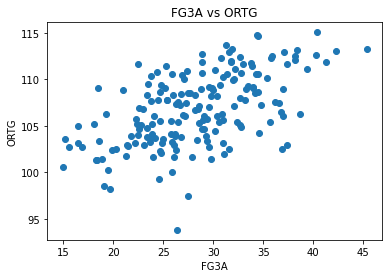

In [532]:
plt.xlabel("FG3A")
plt.ylabel("ORTG")
plt.plot(record['FG3A'], record['ORTG'], "o")
plt.title("FG3A vs ORTG")
plt.show()

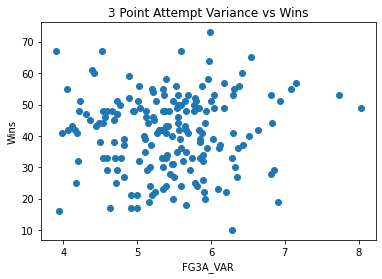

In [533]:
plt.xlabel("FG3A_VAR")
plt.ylabel("Wins")
plt.plot(record['FG3A_VAR'], record['WINS'], "o")
plt.title("3 Point Attempt Variance vs Wins")
plt.show()

After looking at the two plots, we can see a decent correlation between 3 point shots attempted and offensive rating. However on the second plot, the variance between attempts per game had no real effect on wins. \Looking at this data was a good warmup before starting the true modeling, but didn't really yield any significant findings.

# Start the Modeling

There will be main types of modeling I will be doing. I will be modeling the total (total points scored in the game) and the spread (margin of victory). To start I will be looking at modeling the total. This will just be looking at the two teams statistics and trying to predict how many points will be scored total.

## Total Modeling
### Linear Regression
To start modeling the total I want to just look at what a simple linear regression would yield and how effective would it be. I'd also look to at how different columns effect the model by looking at the p values. I can tell we have WAY too many variables to determine the total of a game. But for the sake of the process I'd like to look at how the majority of them will effect.

Our features (x) will be the home and away values for all of the values below. Some of the essential ones I'll start with are all the ones not including variance. 

In [534]:
x_cols = []

for col in record.columns:
    if not 'VAR' == col[-3:] and not col == 'WINS' and not col == 'MONTH' and not col == 'REST':
        x_cols.append('H_' + col)    
        x_cols.append('A_' + col)    

reg = sm.OLS(games[['TOTAL_PTS']], games[x_cols]).fit()
reg

games[x_cols]

,H_PPG,A_PPG,H_FGM,A_FGM,H_FGA,A_FGA,H_FG_PCT,A_FG_PCT,H_FG3M,A_FG3M,...,H_POSS,A_POSS,H_eFGP,A_eFGP,H_TOV%,A_TOV%,H_ORTG,A_ORTG,H_PACE,A_PACE
0,99.353659,95.695122,37.902439,37.512195,82.865854,82.829268,0.458512,0.453598,7.146341,6.756098,...,93.580488,95.531707,0.501911,0.494672,13.429777,14.951060,106.249806,100.257027,93.096434,95.209020
1,103.182927,105.219512,39.121951,39.695122,83.585366,85.804878,0.469659,0.463537,8.256098,8.926829,...,96.631220,97.779512,0.519066,0.515935,13.934310,12.809583,106.882168,107.775637,95.370187,96.721570
2,98.451220,103.926829,37.243902,36.975610,85.609756,83.317073,0.435646,0.444720,6.487805,11.378049,...,97.004878,99.018537,0.473688,0.513576,13.000413,16.063030,101.429395,105.053191,95.826127,98.351109
3,94.158537,97.841463,35.524390,37.597561,84.536585,81.975610,0.420634,0.460744,6.073171,6.646341,...,95.725366,96.560488,0.456766,0.501757,11.647954,16.541460,98.507540,101.375889,94.590762,95.351963
4,97.329268,91.975610,36.560976,33.719512,83.219512,82.646341,0.440646,0.409012,7.463415,8.439024,...,95.859512,98.101463,0.485847,0.460212,13.872311,17.198706,101.758284,93.830702,94.974310,97.411037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6204,106.475610,109.390244,37.658537,40.634146,86.207317,91.329268,0.436976,0.445695,13.195122,11.939024,...,97.758537,99.006829,0.513713,0.511147,12.649069,11.720386,109.017065,110.570031,97.185760,98.108440
6205,104.231707,110.024390,38.280488,39.585366,88.292683,84.804878,0.434037,0.468049,12.182927,13.585366,...,101.660488,98.138049,0.503046,0.548439,13.592302,14.002763,102.563362,112.290373,101.164362,97.240176
6206,109.939024,104.829268,39.390244,38.158537,84.536585,88.621951,0.467098,0.431390,11.585366,11.280488,...,98.234146,100.727317,0.535978,0.495060,11.923723,13.261972,111.878468,104.196588,97.597072,100.308312
6207,114.829268,110.304878,43.670732,40.500000,90.109756,88.085366,0.485707,0.460927,11.597561,11.426829,...,101.456098,102.299024,0.550223,0.525913,12.149135,13.245609,113.245278,107.797177,101.140297,101.629313


In [535]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              TOTAL_PTS   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          2.011e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:01:18   Log-Likelihood:                         -26808.
No. Observations:                6209   AIC:                                  5.370e+04
Df Residuals:                    6167   BIC:                                  5.398e+04
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
H_PPG            0.9050      1.518      0.596      0.551      -2.071       3.881
A_PPG            1.6445      1.519      1.082      0.279      -1.334       4.623
H_FGM           -4.3530      2.527     -1.723      0.085      -9.307       0.601
A_FGM           -0.1262      2.565     -0.049      0.961      -5.155       4.903
H_FGA           -7.7229      6.938     -1.113      0.266     -21.324       5.878
A_FGA           -0.0367      6.925     -0.005      0.996     -13.613      13.540
H_FG_PCT        32.1862    781.170      0.041      0.967   -1499.179    1563.552
A_FG_PCT      -194.9901    792.393     -0.246      0.806   -1748.356    1358.376
H_FG3M           4.2270      3.948      1.071      0.284      -3.512      11.966
A_FG3M           4.0977      3.987      1.028      0.304      -3.718      11.913
H_FG3A          -2.2852      0.815     -2.805      0.005      -3.882      -0.688
A_FG3A          -2.0003      0.816     -2.451      0.014      -3.600      -0.400
H_FG3_PCT     -146.0289     62.350     -2.342      0.019    -268.257     -23.801
A_FG3_PCT     -142.5855     62.552     -2.279      0.023    -265.209     -19.962
H_FTM            5.3841      2.693      2.000      0.046       0.106      10.663
A_FTM           -2.2008      2.715     -0.810      0.418      -7.524       3.122
H_FTA           -7.6767      3.581     -2.144      0.032     -14.696      -0.657
A_FTA            1.4294      3.595      0.398      0.691      -5.618       8.477
H_FT_PCT       -93.7565     52.629     -1.781      0.075    -196.927       9.414
A_FT_PCT        17.3675     53.232      0.326      0.744     -86.986     121.721
H_OREB           8.1605      4.747      1.719      0.086      -1.145      17.466
A_OREB          -0.2549      4.756     -0.054      0.957      -9.577       9.068
H_DREB          -4.5217      2.378     -1.902      0.057      -9.183       0.140
A_DREB          -0.4679      2.383     -0.196      0.844      -5.140       4.205
H_REB            3.6388      2.384      1.527      0.127      -1.034       8.312
A_REB           -0.7227      2.387     -0.303      0.762      -5.402       3.956
H_AST           -0.0689      0.195     -0.353      0.724      -0.451       0.313
A_AST            0.2648      0.194      1.365      0.172      -0.115       0.645
H_STL           -0.6709      0.515     -1.302      0.193      -1.681       0.339
A_STL           -1.0854      0.515     -2.108      0.035      -2.095      -0.076
H_BLK            0.0062      0.367      0.017      0.987      -0.713       0.726
A_BLK           -0.3069      0.368     -0.834      0.404      -1.028       0.415
H_PF            -0.6411      0.222     -2.886      0.004      -1.077      -0.206
A_PF            -0.1574      0.221     -0.713      0.476      -0.590

Some things to note for our very first linear regression model. The model actually fits the model quite good with an R^2 of .993 and a very small f-stastistic. It also notes at the bottom that there are very strong multicollinearity problems with this first model which makes sense. We have many multicollinearity with DREB, OREB and TREB. same can be said about FGM, FGA and FG%. We'll need to eliminate these collinearities in the future models but would like to go forward with this simple model. Let's take a look at all the P-values for each of these variables. 

In [536]:
# for col in x_cols:
#     print("Attribute: " + col + " P value: " + reg.pvalues[col])
reg.pvalues

H_PPG           0.551047
A_PPG           0.279158
H_FGM           0.085010
A_FGM           0.960776
H_FGA           0.265709
A_FGA           0.995774
H_FG_PCT        0.967136
A_FG_PCT        0.805630
H_FG3M          0.284303
A_FG3M          0.304059
H_FG3A          0.005043
A_FG3A          0.014287
H_FG3_PCT       0.019208
A_FG3_PCT       0.022673
H_FTM           0.045588
A_FTM           0.417700
H_FTA           0.032079
A_FTA           0.690918
H_FT_PCT        0.074884
A_FT_PCT        0.744237
H_OREB          0.085635
A_OREB          0.957260
H_DREB          0.057280
A_DREB          0.844389
H_REB           0.126936
A_REB           0.762062
H_AST           0.723950
A_AST           0.172148
H_STL           0.192876
A_STL           0.035081
H_BLK           0.986583
A_BLK           0.404480
H_PF            0.003919
A_PF            0.476024
H_PLUS_MINUS    0.021469
A_PLUS_MINUS    0.033044
H_POSS          0.065994
A_POSS          0.822464
H_eFGP          0.365734
A_eFGP          0.981845


## Testing
To test this model I'm going to go back through our games dataframe and backtest this model, as I will do in the future. To evaluate this model, I'll predict each game with this very simple linear regression. I'm going to add a column to our games to see what it would predict for each game scored. I will call this first model the sausage because it has everything in it. 

In [537]:
games['SAUSAGE'] = reg.predict(games[x_cols])
over = games[games['SAUSAGE'] > games['TOTAL']]
o = len(over[over['TOTAL_PTS'] > over['TOTAL']]) # won over
under = games[games['SAUSAGE'] < games['TOTAL']]
u = len(under[under['TOTAL_PTS'] < under['TOTAL']]) # won under
(o + u) / len(games)

0.5266548558544049

## More Model Development
Now that I have practiced creating a very simple model and testing against betting lines, I hope to come up with more robust ones. In our original model, there was tons of multicollinearity and a lot of unnecessary variables that don't really impact the game. After doing some research online and my own quanders here are the statistics I'd like to develop my models around. 

Rest - In a previous project, I aalyzed rests effects on NBA games. I think it goes unlooked at by a lot of other models available so I hope to use mine.

ORtg - This a robust stat that measures how good an offense truly is. It is possessions adjusted. All of NBA media and statisticians commonly use it to rank offenses. This is a great stat for our model on totals. 

PACE - This is a statistic on how quick a team essentially plays. It's essentially the amount of possessions per 48 minutes.

TOV% - This is how many turnovers a team has per possession.

eFGP - Effective field goal percentage is a lot like FG% except it combines all types of field goals and values three point baskets more.

DR and OR - The amount of DR and OR a team has indicates how many second chance oppurtunities they obtain and allow. 

FTA, FT PCT, 3PA and 3P PCT - All this statistics indicate how well a team shoots free throws and threes and how often they do this. 

#### Adjusting rest
Right now rest is not entirely ready to be modeled. For the first set of games each season, I set there rest as -1 to be addressed later. To impute these values I think it would be best to fill them with the maximum rest a team has all season, as the teams will be the freshest at the beginning of these seasons. 

In addition, I would like to standardize the rest data. It just feels sort of weird to me statistics wise to keep it as days from your past game. I'd like a team with zero rest to have some negative impact and a team with average rest to not actually impact the game. So I will also standardize this column using z scores.

In [546]:
## Max value
max_rest = max(m_sched['REST'])

games['A_REST'] = games.apply(lambda row: row['A_REST'] if row['A_REST'] >= 0 else max_rest, axis=1)
games['H_REST'] = games.apply(lambda row: row['H_REST'] if row['H_REST'] >= 0 else max_rest, axis=1)

games['A_REST'] = (games['A_REST'] - games['A_REST'].mean()) / games['A_REST'].std()
games['H_REST'] = (games['H_REST'] - games['H_REST'].mean()) / games['H_REST'].std()

games['H_eFGP'] = (games['H_eFGP'] - games['H_eFGP'].mean()) / games['H_eFGP'].std()
games['A_eFGP'] = (games['H_eFGP'] - games['H_eFGP'].mean()) / games['H_eFGP'].std()

### Gold Model
Now, with the stats I outlined above I am going to develop a couple models with them as variables. I'll start again with linear regression to see if it will out performed the 'sausage' model. I'll also try using a logistic regression model, gradient descent, and neural networks just to get some practice with them and see if they will out perform the others.

In [563]:
goldcols = ['REST', 'ORTG', 'PACE', 'TOV%', 'eFGP', 'DREB', 'OREB']

gold_cols = []

for col in goldcols:
    gold_cols.append('A_' + col)
    gold_cols.append('H_' + col)
    
gold_lin = sm.OLS(games[['TOTAL_PTS']], games[gold_cols]).fit()
gold_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              TOTAL_PTS   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          5.841e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):                        0.00
Time:                        19:22:11   Log-Likelihood:                         -26921.
No. Observations:                6209   AIC:                                  5.387e+04
Df Residuals:                    6195   BIC:                                  5.396e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A_REST         0.2756      0.238      1.158      0.247      -0.191       0.742
H_REST         0.0053      0.238      0.022      0.982      -0.461       0.472
A_ORTG        -0.3022      0.209     -1.443      0.149      -0.713       0.108
H_ORTG        -0.2570      0.210     -1.226      0.220      -0.668       0.154
A_PACE         1.8884      0.116     16.263      0.000       1.661       2.116
H_PACE         1.6842      0.115     14.603      0.000       1.458       1.910
A_TOV%        -1.1291      0.324     -3.481      0.001      -1.765      -0.493
H_TOV%        -1.0609      0.323     -3.281      0.001      -1.695      -0.427
A_eFGP         3.8781      0.850      4.560      0.000       2.211       5.545
H_eFGP         3.7678      0.851      4.427      0.000       2.100       5.436
A_DREB        -1.3030      0.193     -6.760      0.000      -1.681      -0.925
H_DREB        -0.9580      0.191     -5.006      0.000      -1.333      -0.583
A_OREB         1.2096      0.320      3.780      0.000       0.582       1.837
H_OREB         1.2411      0.319      3.895      0.000       0.616       1.866
==============================================================================
Omnibus:                      121.288   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.130
Skew:                           0.271   Prob(JB):                     2.51e-33
Kurtosis:                       3.535   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [564]:
games['GOLD_LIN'] = gold_lin.predict(games[gold_cols])
over = games[games['GOLD_LIN'] > games['TOTAL']]
o = len(over[over['TOTAL_PTS'] > over['TOTAL']]) # won over
under = games[games['GOLD_LIN'] < games['TOTAL']]
u = len(under[under['TOTAL_PTS'] < under['TOTAL']]) # won under
(o + u) / len(games)

0.5131261072636495

This Gold Model was much worse than our sausage model. But I want to examine how the sausage and gold model would do if all games weren't bet - only games at a certain confidence threshold. I'll look at no margin, three point margin, five point margin, seven and half, and a ten point margin. How will these two models fair when we factor some sort of confidence in the mix.

In [569]:
margins = [0, 3, 5, 7.5, 10]
models = ['SAUSAGE', 'GOLD_LIN']
performance = pd.DataFrame(columns = ['Model', '0', '3', '5', '7.5', '10'])

for mod in models:
    row = [mod]
    for mrg in margins:
        over = games[games[mod] > games['TOTAL'] + mrg]
        o = len(over[over['TOTAL_PTS'] > over['TOTAL']])
        under = games[games[mod] + mrg < games['TOTAL'] ]
        u = len(under[under['TOTAL_PTS'] < under['TOTAL']])
        row = row + [(o + u) / (len(over) + len(under))]
    performance.loc[len(performance.index)] = row

In [570]:
performance

,Model,0,3,5,7.5,10
0,SAUSAGE,0.526655,0.543385,0.557371,0.559857,0.596463
1,GOLD_LIN,0.513126,0.521148,0.524092,0.535354,0.550218


As expected, both of the models got much better as the confidence threshold for games were increased. However, it remained that each threshold that our 'sausage' model, the model with almost all variables included vastly outperformed the gold model. This is extremely anecdotal but its interesting that the model with over 100 variables outperformed the one with only a few, very solid variables. 

## Spread Modeling
I'm very excited and interested in modeling the spread of games. The modeling for totals was rather straight forward: take a bunch of variables and try to model some value of points that would be scored in that game. However, when we model the spread there is more possible exploitation. Of course we simply model the amount of points the home team will win by. Then we could compare to this spread the same way we did with the total. But I'd also like to explore the possibilities of modeling the games as a possibility that the home team wins with the spread factored in. I'd like some practice using random forests and neural networks. So, having said that, I think it would be interesting to model the spread like this.

### Linear Regression
To start off on modeling on the spread, I would like to just run a simple linear regression model. The same columns will be used from the 'SAUSAGE' model above, but we'll fit it to the margin of the game. I'll then evaluate its performance. To model the spread itself, I'll attempt 

In [580]:
x_cols = []

for col in record.columns:
    if not 'VAR' == col[-3:] and not col == 'WINS' and not col == 'MONTH' and not col == 'REST':
        x_cols.append('H_' + col)    
        x_cols.append('A_' + col)    

reg = sm.OLS(games[['MARGIN']], games[x_cols]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 MARGIN   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.229
Method:                 Least Squares   F-statistic:                              44.99
Date:                Wed, 10 Aug 2022   Prob (F-statistic):                   8.63e-320
Time:                        01:04:34   Log-Likelihood:                         -24460.
No. Observations:                6209   AIC:                                  4.900e+04
Df Residuals:                    6167   BIC:                                  4.929e+04
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
H_PPG            0.0616      1.227      0.050      0.960      -2.344       2.467
A_PPG           -0.0765      1.234     -0.062      0.951      -2.495       2.342
H_FGM            0.9813      1.686      0.582      0.561      -2.324       4.287
A_FGM            0.5885      1.710      0.344      0.731      -2.763       3.940
H_FGA           -1.7598      5.305     -0.332      0.740     -12.160       8.640
A_FGA           -2.7385      5.293     -0.517      0.605     -13.115       7.638
H_FG_PCT      -262.3108    478.722     -0.548      0.584   -1200.773     676.152
A_FG_PCT       123.8125    485.633      0.255      0.799    -828.197    1075.822
H_FG3M          -2.2099      2.471     -0.894      0.371      -7.055       2.635
A_FG3M          -0.8604      2.493     -0.345      0.730      -5.747       4.026
H_FG3A           0.3451      0.566      0.609      0.542      -0.765       1.456
A_FG3A           0.6017      0.568      1.059      0.289      -0.512       1.715
H_FG3_PCT       32.6342     43.439      0.751      0.453     -52.521     117.789
A_FG3_PCT       59.9632     43.594      1.375      0.169     -25.496     145.422
H_FTM            0.3088      1.813      0.170      0.865      -3.246       3.864
A_FTM           -0.3931      1.832     -0.215      0.830      -3.985       3.198
H_FTA           -1.1360      2.634     -0.431      0.666      -6.300       4.028
A_FTA           -0.8353      2.638     -0.317      0.752      -6.007       4.337
H_FT_PCT       -25.7574     36.083     -0.714      0.475     -96.493      44.978
A_FT_PCT         3.9635     36.481      0.109      0.913     -67.551      75.478
H_OREB           0.6760      3.521      0.192      0.848      -6.227       7.579
A_OREB           1.6335      3.523      0.464      0.643      -5.273       8.540
H_DREB          -0.3894      1.764     -0.221      0.825      -3.847       3.068
A_DREB          -0.7819      1.766     -0.443      0.658      -4.243       2.679
H_REB            0.2866      1.767      0.162      0.871      -3.177       3.751
A_REB            0.8516      1.767      0.482      0.630      -2.612       4.315
H_AST           -0.1335      0.135     -0.992      0.321      -0.397       0.130
A_AST            0.0539      0.134      0.403      0.687      -0.208       0.316
H_STL           -0.1933      0.353     -0.548      0.584      -0.885       0.498
A_STL            0.0779      0.353      0.221      0.825      -0.613       0.769
H_BLK           -0.2678      0.252     -1.063      0.288      -0.762       0.226
A_BLK           -0.1266      0.253     -0.500      0.617      -0.622       0.369
H_PF            -0.0403      0.152     -0.265      0.791      -0.338       0.258
A_PF             0.0330      0.151      0.218      0.827      -0.264

In [585]:
games['S_SAUSAGE'] = reg.predict(games[x_cols])
home = games[games['S_SAUSAGE'] > -games['SPREAD']]
h = len(home[home['MARGIN'] > -home['SPREAD']]) # won home spread
away = games[games['S_SAUSAGE'] < -games['SPREAD']]
a = len(away[away['MARGIN'] < -away['SPREAD']]) # won away spread
(h + a) / len(games)

0.5272990819777742